# <h1 align="center">Empirical Methods Basic Time Series</h1> 

###
# Problem 1: Building a simple autocorrelation-based forecasting model
Fama and French (2015) propose a five-factor model for expected stock returns. One of the
factor is based on cross-sectional sorts on firm profitability. In particular, the factor portfolio
is long form with high proftability (high earnings divided by book equity; high ROE) and
short firms with low profitability (low earnings divided by book equity; low ROE). This
factor is called RMW ñRobust Minus Weak.

1. Go to Ken Frenchís Data Library (google it) and download the Fama/French 5 Factors (2x3) in CSV format. 

    - Denote the time series of value-weighted monthly factor returns for the RMW factor from 1963.07-2021.10 as "rmw." Plot the time-series. 
    - Give the annualized mean. 
    - Give annualized standard deviation of this return series.


In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats, linalg
import matplotlib.pyplot as plt
from datetime import datetime
from functools import reduce
# file = r"C:\Users\user\Documents\F-F_Research_Data_5_Factors_2x3.csv"
file_daily = r"C:\Users\user\Documents\F-F_Research_Data_5_Factors_2x3_daily.csv"


In [2]:
#Cleaning Data
# This was annoying but this is kind of a slick way to parse all dataframs that's liken to FF library. 
#I'm setting up the dateparse command and assigning it to dateparse variable which I will use in pythons built in function read_csv's parameter, date_parser.
dateparse = lambda x: pd.datetime.strptime(x,'%Y%m%d') 
# index_col is going to put your first column in the csv matrix as a dataframe.  I deleted csv rows i didn't need to make importing easier.
f_f_FF = pd.read_csv(file_daily, index_col=0, parse_dates=True, date_parser = dateparse)
RMW_FF = f_f_FF.iloc[:, [3]]

#--------------------------------------------------------------------------------------------------------------------------------------------
# Denote the time series of value-weighted monthly factor returns for the RMW factor from 1963-07 to 2021.10
begin_date = "1960-07-01"
end_date = "2021-08-31"
RMW_FF = RMW_FF.loc[begin_date:end_date]
# lets get this monthly
RMW_FF = RMW_FF.resample('M').sum()


<ipython-input-2-f69bae18a32a>:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda x: pd.datetime.strptime(x,'%Y%m%d')


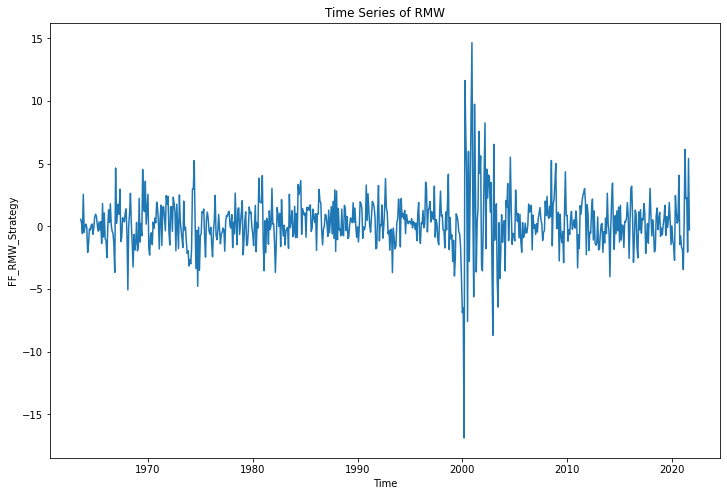

In [3]:
#Plot Plot Time Series monthly 
plt.figure(figsize=(12,8))
plt.plot(RMW_FF.index, RMW_FF.RMW)
plt.xlabel('Time')
plt.ylabel('FF_RMW_Strategy')
plt.title("Time Series of RMW")
plt.show()

In [4]:
#Average Annual Return and Vol for RMW Strategy I changed to sum here. 
annual_ret = RMW_FF.RMW.resample("Y").sum()
# It looks like these are already Log Returns so I'm taking the Average. Sai may want to double check
# annual_rets = np.log(annual_ret/annual_ret.shift(1)).dropna()
# annual_rets[0:6]

In [5]:
avg_annual_rets = annual_ret.mean()
avg_annual_vol = annual_ret.std()

dict_Ret = {"Avg_annual_ret" : avg_annual_rets}
dict_vol = {"Avg_annual_vol": avg_annual_vol}

df_vol = pd.DataFrame(dict_vol, index = [0], columns = dict_vol.keys())
df_Ret = pd.DataFrame(dict_Ret, index = [0], columns = dict_Ret.keys())

df_RMW = pd.merge(df_vol, df_Ret, left_index = True, right_index=True)

df_RMW


,Avg_annual_vol,Avg_annual_ret
0,8.580161,3.214237


### 2. Auto Corrleations:

- Plot the 1st to 60th order autocorrelations of rmw. 
- plot the cumulative sum of these autocorrelations (that is, the 5th observation is the sum of the First 5 autocorrelations, the 11th observation is the sum of the first 11 autocorrelations, etc.). 
- Describe these plots. In particular, do the plots hint at predictabilty of the factor returns? What are the salient patterns, if any?

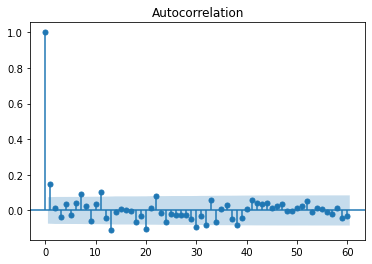

In [6]:
df_RMW = RMW_FF[["RMW"]].iloc[::-1]
df_RMW.columns
plot = sm.graphics.tsa.plot_acf(df_RMW["RMW"], lags = 60)


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


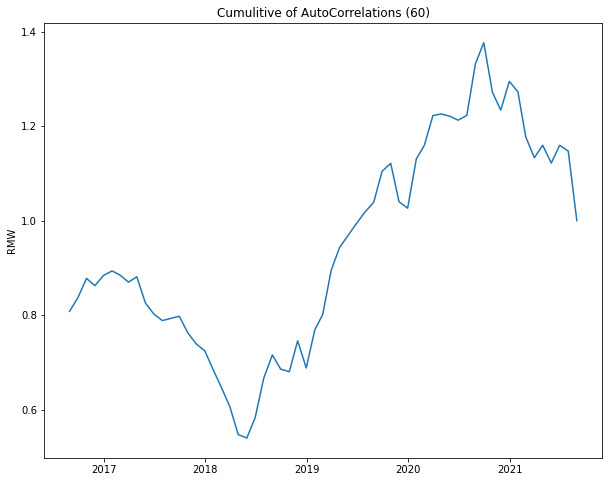

In [7]:
df_RMW.reset_index(inplace = True)
x = df_RMW.date.iloc[:61]
y = sm.tsa.stattools.acf(df_RMW.RMW, nlags =60).cumsum()
plt.figure(figsize=(10,8))
plt.plot(x,y)
plt.ylabel('RMW')
plt.title("Cumulitive of AutoCorrelations (60)")
plt.show()

In [8]:
df_RMW['date'] = pd.to_datetime(df_RMW['date'])
df_RMW.set_index('date', inplace = True)

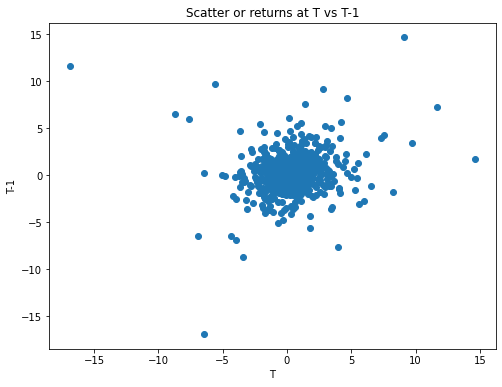

In [9]:
x = df_RMW['RMW'][1:]
y = df_RMW["RMW"].shift(1).dropna()
plt.figure(figsize=(8,6))
plt.scatter(x,y)
plt.ylabel('T-1')
plt.xlabel("T")
plt.title("Scatter or returns at T vs T-1")
plt.show()

### 3. Perform a Ljung-Box test that the first 6 autocorrelations jointly are zero. 
    Write out the form of the test and report the p-value. What do you conclude from this test?
    
    A:  The below result doesn't reconcile.  It should display low Autocorrelation it would seem.  Potential errors:  
        - Operator ignorance (me).  Perhaps I don't know what I'm looking at? Did I take a metric like the return in an incorrect manner?
        

In [18]:
# df_RMW['RMW'].corr().max()

In [16]:

# Numpy array returned is: [T-test, p-value]
sm.stats.acorr_ljungbox(df_RMW['RMW'], lags = [14])

C:\Users\user\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


(array([47.34190151]), array([1.68844549e-05]))

### 4.)  Based on your observations in (2) and (3), propose a parsimonious forecasting model for rmw for: 


### $ RMW_{t+1} =  \beta_1x_{t} + \epsilon_{t+1}$ 

where the first variable in $x_{t}$ is a 1 for the intercept in the regression.  

Choose the remaining variables in $x_{t}$ ==> it could be only one more or a longer K x 1 vector. While this analysis is in-sample, I do want you to argue for your variables by attaching a "story" to your model that makes it more ex ante believeable. (PS: This question is purposefully a little vague. There is not a single correct answer here, just grades of more to less reasonable as in the real world).

---
### Analysis 

What I'm understanding is that we are to use "information" up until time $t$ to forecast $t+1$ while setting the $X_{t}$ term to 1(intercept term).  I could run an AR(1) given the plot but that wouldn't make the x term 1 as it would be for an AR(1) model. Lets try a Multi-factor Model of the other FF betas to predict RMW and then lets try and AR(1) model given our previous ACF_Plot deemed that this could potentially be useful. 

In [19]:
#Create the necessary dataframe with appropriate lags to run the regression 
#Set index
df_ff = f_f_FF.iloc[::-1]
multi_RMW = sm.OLS(df_ff['RMW'], sm.add_constant(df_ff[['Mkt-RF','SMB','HML', "CMA"]]))
RMW_out = multi_RMW.fit()
print(RMW_out.summary())

                            OLS Regression Results                            
Dep. Variable:                    RMW   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     486.8
Date:                Mon, 10 Jan 2022   Prob (F-statistic):               0.00
Time:                        09:06:49   Log-Likelihood:                -5843.3
No. Observations:               14706   AIC:                         1.170e+04
Df Residuals:                   14701   BIC:                         1.173e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0167      0.003      5.602      0.0

C:\Users\user\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


(array([0.00387016]), array([0.95039512]))

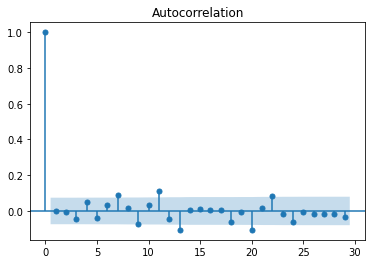

In [20]:
#AR(1) Model
ar_RMW = sm.OLS(df_RMW['RMW'], sm.add_constant(df_RMW['RMW'].shift(1)), missing = 'drop').fit().resid
sm.graphics.tsa.plot_acf(ar_RMW)
sm.stats.acorr_ljungbox(ar_RMW, lags = [1])



In [22]:
# AR(1) Model output. 
ar_RMW = sm.OLS(df_RMW['RMW'], sm.add_constant(df_RMW['RMW'].shift(1)), missing = 'drop').fit()
ar_1 = ar_RMW.summary()
print(ar_1)

                            OLS Regression Results                            
Dep. Variable:                    RMW   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     15.42
Date:                Mon, 10 Jan 2022   Prob (F-statistic):           9.48e-05
Time:                        09:07:32   Log-Likelihood:                -1523.9
No. Observations:                 697   AIC:                             3052.
Df Residuals:                     695   BIC:                             3061.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2325      0.082      2.824      0.0

### Conclusion (4):

    - Niether factor returns (which we expected) nor the AR(1) model (unexpected) results returned a significant result where we could have any confidence in the models efficacy out of sample given low adjusted r-squared explanatory results. 
    
    - Reasons:  Most likely the model was specified improperly and we are also missing the factors that provide us the information necessary to (given a proper specification) forecast RMW with a high adjusted R^2. Said differently, it doesn't make sense to even look at the coefficient standard errors because the adjusted r^2 is so low on both models. 

### 5. Estimate the proposed model and Report Robust (White) standard errors for  $\hat{\beta}_{white}$, as well as the regular  $\hat{\beta}_{OLS}$ standard errors.

---------------

### 5) Analysis & Conclusion 

We will use the factor model as the AR(1) model is all noise.  

### $RMW_{t + 1} = \alpha + \beta_{mkt}X_{mkt_t} + \beta_{SMB}X_{SMB_t} + \beta_{HML}X_{HML_t} + \beta_{CMA}X_{CMA_t}$



In [23]:
#Predicting the next period script:
# -------------------------------------------------------
df_ff = f_f_FF.iloc[::-1]
X = df_ff[['Mkt-RF','SMB','HML', "CMA"]]
# print(X.shape)
y = df_ff['RMW']
X = sm.add_constant(X)
multi_RMW = sm.OLS(y, X)
RMW_out = multi_RMW.fit()
 # adding a constant
X.shape
#Prediction
y_pred = RMW_out.predict(X)
#print out Results 
y_pred[0]
print(f"Coefficients:\n{RMW_out.params}\n.")
print(f"OLS Standard errors:\n{RMW_out.bse}\n")
print(f"White Standard errors:\n{RMW_out.HC0_se}")
print(f"Predicted values:\n{RMW_out.predict()[0]}")

Coefficients:
const     0.016662
Mkt-RF   -0.077998
SMB      -0.199770
HML       0.005678
CMA       0.030724
dtype: float64
.
OLS Standard errors:
const     0.002974
Mkt-RF    0.003139
SMB       0.005578
HML       0.006364
CMA       0.010213
dtype: float64

White Standard errors:
const     0.002973
Mkt-RF    0.005312
SMB       0.009593
HML       0.013482
CMA       0.020688
dtype: float64
Predicted values:
0.14272399467633243


# Problem 2: Nonstationarity and regression models

### Question 1:

Simulate Time series observations each of of the following two return series N-times:

-  $r_{1,t} = \mu + \sigma\epsilon_{1,t}$; 

- $r_{2,t} = \mu + \sigma\epsilon_{2,t}$

where $\mu$= 0.6%, $\sigma$ = 5%, and the residuals are uncorrelated standard Normals. Let T= 600 and N= 10;000.

For each of the N-time-series, regress:

- $r_{1,t} = \alpha + \beta r_{2,t} + \epsilon_{t_{1}}$

Save the slope coeficient as $\beta^{n}$), where n= 1;:::;N. Give the mean and standard
deviation of  across samples nand plot the histogram of the 10;000 samples. Does this
correspond to the null hypothesis $H:0 = 0$? Do the regress standard errors look ok?


In [130]:
#simple function to utilize in loops
def reg(mu, sigma):
    """Returns a simple return with some noise"""
    r = mu + sigma*np.random.normal()
    return r 
# Possibly a more efficient way to do but this seems to work. 
r_1, r_2= [],[]

T= 600
n = 10000
mu = .006
sigma = .05


In [131]:
bsim = list()

for ii in range(0, n):
    r_1, r_2 = [], []
    for jj in range(1, T+1):
        re_1 = reg(mu, sigma)
        re_2 = reg(mu, sigma)
        r_1.append(re_1)
        r_2.append(re_2)
        
    b = sm.OLS(r_1, sm.add_constant(r_2), missing = 'drop').fit().params[1]
    bsim.append(b)

print(f"The coefficient mean is {np.array(bsim).mean().round(5)}.")
print(f"The coefficient standard error is {np.array(bsim).std()}.")

The coefficient mean is -0.00028.
The coefficient standard error is 0.04093158121273048.


[Text(0.5, 0, 'bsim'),
 Text(0, 0.5, 'Frequency'),
 Text(0.5, 1.0, 'Histogram of Slope Coefficient')]

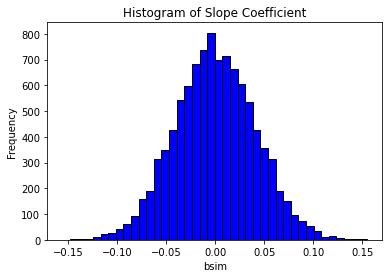

In [132]:
#Plot Hist
fig = plt.figure()
ax = fig.add_subplot()
ax.hist(bsim, bins = 40, ec='black', fc='blue')
ax.set(xlabel = 'bsim', ylabel='Frequency', title = 'Histogram of Slope Coefficient')


### Analysis and Conclusion to question 1 (P2):

The slope coefficients looks normally distributed and similar to zero.

## 2. Construct the $N$ price sample of length $T$ based on each return using:

- $P_{1,t} = P_{1, t-1} + r_{1,t}$
- $P_{2,t} = P_{2, t-1} + r_{2,t}$

Using $P_{1,0} = P_{2,0} = 0$ as the initial condition. Repeat the exercise using the regression: $P_{1,t} = \alpha + \beta P_{2,t} + \epsilon_{t}$

Again report the mean and standard deviation of the $N$ estimated $\beta$ 's and plot the
histogram. Does this correspond to the null hypothesis $H0: = 0$? Do the regression
standard errors look ok? Explain what is going on here that is different from the
previous return-based regressions.


In [136]:
#List of simmulated betas and other fun standard error metrics
white_SE = list()
OLS_SE = list()
bsim = list()
#Place variables
t = 600
n = 10000
mu = .006
sigma = .05
# Run Simulations on two random price series
for ii in range(0,n):
    #Setting the two price series as empty numpy arrays
    p_1, p_2 = np.zeros([0]), np.zeros([0])
    for jj in range(0, t):        
        ic_1 = 0
        ic_2 = 0       
        #Returns to add up 
        re_1 = reg(mu, sigma)
        re_2 = reg(mu, sigma)        
        if len(p_1) == ic_1:
            #Get 0 in the first element
            p_1 = np.append(p_1, ic_1)
            p_2 = np.append(p_2, ic_2)
        else:
            #Build up the array
            price_nxt1 = p_1[jj-1] + re_1
            price_nxt2 = p_1[jj-1] + re_2
            p_1 = np.append(p_1, price_nxt1)
            p_2 = np.append(p_2, price_nxt2)
    #create betas of each sample of 600 iterations to construct 10000 beta distribution
    fit = sm.OLS(p_1, sm.add_constant(p_2), missing = 'drop').fit()
    b = fit.params[1]
    bsim.append(b)    
    OLS = fit.bse
    white = fit.HC0_se
    OLS_SE.append(OLS)
    white_SE.append(white)       

In [140]:
print(f"The Coefficient mean is: {np.array(bsim).mean().round(5)}\n.")
print(f"The Coefficient standard error is {np.array(bsim).std()}\n.")
print(f"The Average OLS Standard errors:\n{np.array(OLS_SE).mean()}\n")
print(f"The Average White Standard errors:\n{np.array(white_SE).mean()}\n")

The Coefficient mean is: 0.99503
.
The Coefficient standard error is 0.00697751412268636
.
The Average OLS Standard errors:
0.004318410804627796

The Average White Standard errors:
0.004290695125225383



[Text(0.5, 0, 'bsim'),
 Text(0, 0.5, 'Frequency'),
 Text(0.5, 1.0, 'Histogram of Slope Coefficient')]

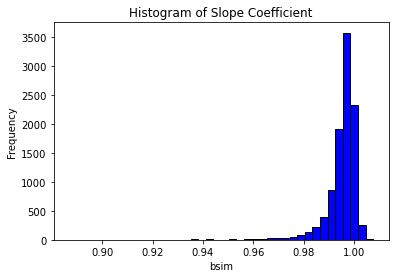

In [141]:
#Plot Hist
fig = plt.figure()
ax = fig.add_subplot()
ax.hist(bsim, bins = 40, ec='black', fc='blue')
ax.set(xlabel = 'bsim', ylabel='Frequency', title = 'Histogram of Slope Coefficient')  

# Analaysis:

This is funny.  Tobias's point in lecture was correct.  Regressing the slope coefficient of a random price series on another random price series produces the appearance of predictive power.   Unfortuately this is not the case. Regressing a return on a return series like we did in one produced the noise that we would expect.  The point is DO NOT predict or regress on non-stationary series or you will get "bunk" for an output. 

In [1]:
# box test on iid random std. normal (reject autocorrelation) #retuns test statistic, p-value.  Saying its not correlated.
sm.stats.acorr_ljungbox(np.random.randn(100), lags = [20])
sm.stats.acorr_ljungbox(df["PPI_Level"], lags = [20]) #retuns test statistic, p-value

ar_2_residual = sm.OLS(y, sm.add_constant(X), missing = 'drop').fit().resid
sm.stats.acorr_ljungbox(ar_2_residual, lags = [20])


NameError: name 'sm' is not defined